# CQF Exam Two

## January 2024 Cohort

## Task (copied from the exam sheet)

Use the expected value of the discounted payoff under the risk-neutral density $\mathbb{Q}$

$$
V(S, t) = e^{-r(T-t)} \mathbb{E}^\mathbb{Q}\left[\textbf{Payoff}(S_T)\right]
$$

for the appropriate form of payoff, to consider **Asian** and **Lookback** options.

Use the **Euler-Maruyama** (only) scheme for initially simulating the underlying stock price. As an initial example you may use the following set of sample data:

\begin{align*}
\text{Today's stock price } S_0 & = 100 \\
\text{Strike } E & = 100 \\
\text{Time to expiry } (T - t) & = 1 \text{ year} \\
\text{Volatility } \sigma & = 20\% \\
\text{Constant risk-free interest rate } r & = 5\%
\end{align*}

Then vary the data to see the affect on the option price.

## Solution

Under risk neutrality, we assume the underlying stock price process $S_t$ follows a Geometric Brownian motion

$$dS_t = rS_t dt + \sigma S_t dW_t,$$

where $S_t$ is the price of the underlying at time $t$, $\sigma$ is constant volatility, $r$ is the constant risk-free interest rate, and $W_t$ is the Brownian motion.

Following [1] + [2], Euler-Maruyama method discretizes the process $S_t$ over the time steps $\delta t$ in the time interval $0 < \delta t < T$ to

$$S(t+\delta t) = S(t) * \left(1+ r\delta t+\sigma  \sqrt{\delta t}\phi\right),$$

where $\phi$ is from a standardized Normal distribution. But since our SDE for the asset path is integrable, we can find the time-stepping algorithm

$$S(t+\delta t) = S(t) * \exp\left[\left(r-\frac{1}{2}\sigma^2\right)\delta t + \sigma\sqrt{\delta t}\phi\right],$$

which is what we will implement in the following.

In [90]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


np.set_printoptions(precision=3)
pd.set_option('display.precision', 4)
warnings.filterwarnings('ignore')

In [91]:
S0 = 100
K = 100  # using K for strike seems more natural for me, so I named this variable K
t = 1
sigma = 0.2
r = 0.05
dt = 0.01
number_of_mc_paths = 50000

#### Generate price paths

Now generate $N=50k$ Monte Carlo asset paths using the discretized time-stepping algorithm for Geometric Brownian motion and store these asset simulations in an array S. Each of these 50k simulations of S will contain $(T-t)/0.01 = 100$ stock prices for each time step $\delta t$ over the course of the observation period until the derivative options expire.

It makes sense to have a high number of Monte Carlo paths (in this case: $N=50000$), because the sources in the Monte Carlo pricing method are of order $\mathcal{O}(N^{-0.5})$. The time step size $\delta t$ should also be chosen as small as possible, since the discretization of continuous events always introduces some imprecisions of order $\mathcal{O}(\delta t)$.

In [92]:
def simulate_stock_price(S0, r, sigma, t, dt, number_of_mc_paths=10000):
    """Simulate stock price using Euler-Maruyama method."""
    N = int(t / dt)  # number of time steps
    S = np.zeros((number_of_mc_paths, N))
    S[:, 0] = S0
    for i in range(1, N):
        dW = np.random.standard_normal(number_of_mc_paths)  # Brownian increment
        S[:, i] = S[:, i-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * dW)  # Euler-Maruyama step
    return S


S = simulate_stock_price(S0, r, sigma, t, dt, number_of_mc_paths)
# S is an array with length = <number_of_mc_paths> containing the simulated asset prices
S

array([[100.   , 100.495, 101.266, ..., 157.402, 155.94 , 160.243],
       [100.   ,  97.466,  93.798, ...,  79.465,  79.38 ,  81.093],
       [100.   ,  95.883,  94.361, ..., 125.907, 128.378, 125.977],
       ...,
       [100.   , 101.056, 103.567, ..., 145.986, 145.003, 137.544],
       [100.   , 104.035, 105.922, ..., 132.053, 131.179, 129.242],
       [100.   ,  99.303,  99.655, ...,  95.382,  95.854,  94.354]])

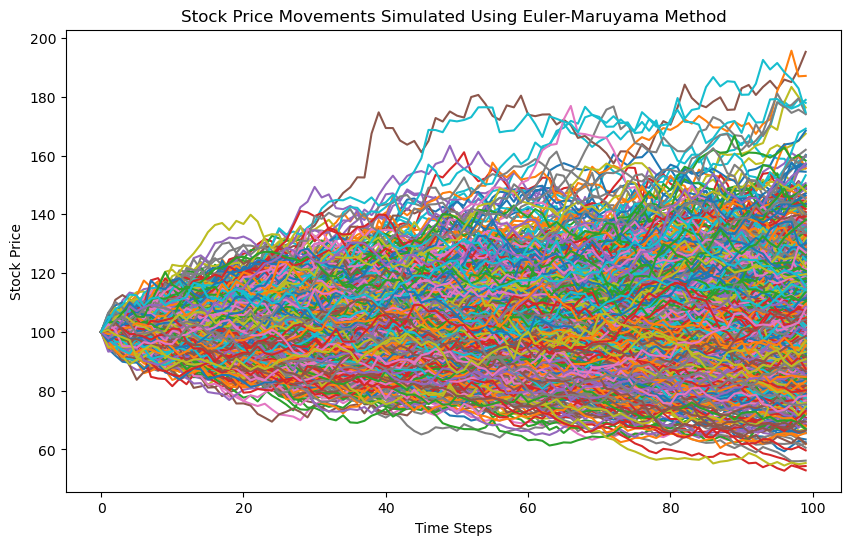

In [93]:
plt.figure(figsize=(10, 6))
for i in range(1000):  # plot the first 1000 paths
    plt.plot(S[i, :])
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Stock Price Movements Simulated Using Euler-Maruyama Method')
plt.show()

#### From asset price to option price

With our asset price simulations generated, we can now calculate the option payoff at expiry, i.e. $\textbf{Payoff}(S_T)$, for every path. This yields $N$ option payoffs for each option type. Under risk-neutral measure $\mathbb{Q}$, the option price at any time $0\leq t\leq T$ is the discounted value of the expected payoff we apply the formula, i.e.

$$V(S, t) = e^{-r(T-t)} \mathbb{E}^\mathbb{Q}\left[\textbf{Payoff}(S_T)\right].$$

We will now implement this formula for **Asian options** and **Lookback options**.

##### Asian options
Asian options depend on the average price of the underlying price $S_t$ for $0<t<T$. Denote this average price by $A$. It follows that
* Asian call payoff = $\max(A-E, 0)$
* Asian put payoff = $\max(E-A, 0)$.

##### Lookback options
Lookback options depend on the maximum price $M$ or minimum price $m$ of the underlying price $S_t$ for $0<t<T$. For a fixed strike $E$, the payoff functions are given by
* Lookback call payoff, fixed strike = $\max(M-E, 0)$
* Lookback put payoff, fixed strike = $\max(E-m, 0)$.

Lookback options with so-called floating strike have payoffs

* Lookback call payoff, floating strike = $\max(S_T-m, 0)=S_T-m$
* Lookback put payoff, floating strike = $\max(M-S_T, 0)=M-S_T$.

In [94]:
def asian_option(S, K, r, t):
    avg = np.mean(S, axis=1)  # mean stock price over the path
    asian_call = np.exp(-r * t) * np.maximum(avg - K, 0)
    asian_put = np.exp(-r * t) * np.maximum(K - avg, 0)
    return np.mean(asian_call), np.mean(asian_put)

def lookback_option(S, K, r, t, fixed_strike=1):
    min_S = np.min(S, axis=1)  # minimum stock price over the path
    max_S = np.max(S, axis=1)  # maximum stock price over the path
    if fixed_strike:
        lookback_call = np.exp(-r * t) * np.maximum(max_S - K, 0)
        lookback_put = np.exp(-r * t) * np.maximum(K - min_S, 0)
    else:  # calculate the option payoffs for floating strike now
        lookback_call = np.exp(-r * t) * np.maximum(S[:, -1] - min_S, 0)
        lookback_put = np.exp(-r * t) * np.maximum(max_S - S[:, -1], 0)
    return np.mean(lookback_call), np.mean(lookback_put)


asian_call, asian_put = asian_option(S, K, r, t)
lookback_fixed_call, lookback_fixed_put = lookback_option(S, K, r, t, fixed_strike=1)
lookback_float_call, lookback_float_put = lookback_option(S, r, t, t, fixed_strike=0)

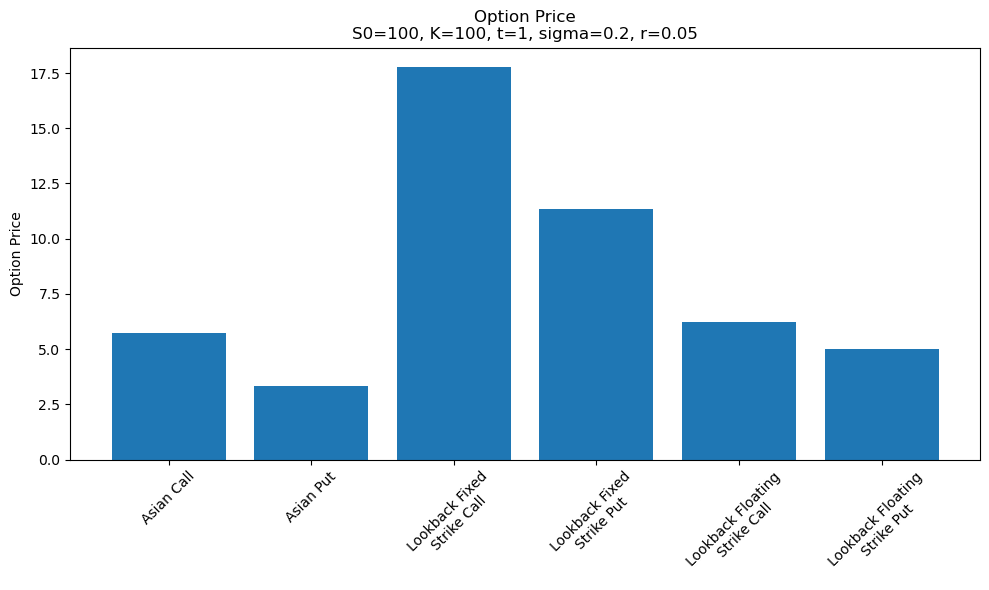

In [95]:
plt.figure(figsize=(10, 6))
labels = ['Asian Call', 'Asian Put',
          'Lookback Fixed\nStrike Call', 'Lookback Fixed\nStrike Put',
          'Lookback Floating\nStrike Call', 'Lookback Floating\nStrike Put']
prices = [asian_call, asian_put, lookback_fixed_call, lookback_fixed_put, lookback_float_call, lookback_float_put]
plt.bar(labels, prices)
plt.ylabel('Option Price')
plt.title(f'Option Price\nS0={S0}, K={K}, t={t}, sigma={sigma}, r={r}')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.show()

## References

* [1]: JA243.4: Lecture Notes on Numerical Methods by Dr. Riaz Ahmad, CQF Faculty, Head of Faculty
* [2]: JA24 Monte Carlo Simulation: CQF Python Labs on Monte Carlo Simulation by Kannan Singaravelu